In [1]:
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Assuming column names have been set as follows:
# movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
# summaries.columns = ['wikipedia_movie_id', 'plot_summary']

# Download necessary NLTK data (run once if needed)
nltk.download('punkt')        # For tokenization
nltk.download('stopwords')    # For stopwords
nltk.download('wordnet')      # For lemmatization

# Initialize necessary NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()  # For Lemmatization
stemmer = PorterStemmer()         # For Stemming (optional)

# Data Preprocessing

Import the data

In [2]:
movies = pd.read_csv('../../data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
characters = pd.read_csv('../../data//MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

# Importing txt files
name_clusters = pd.read_csv('../../data//MovieSummaries/name.clusters.txt', sep = '\t', header = None)
summaries = pd.read_csv('../../data//MovieSummaries/plot_summaries.txt', sep = '\t', header = None)
tv_tropes = pd.read_csv('../../data//MovieSummaries/tvtropes.clusters.txt', sep = '\t', header = None)

We inspect the content of each dataframe

In [3]:
movies.sample(5)

,0,1,2,3,4,5,6,7,8
54310,1183043,/m/04f74c,Kagemusha,1980-05,26000000.0,180.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/02n4lw"":..."
54643,27361432,/m/0bx_mhf,The Redhead and the Cowboy,1951,1250000.0,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":..."
26169,6410861,/m/0g49l3,The Case Of The Stuttering Pig,1937,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01g6gs"": ""Black-and-white""}"
62469,14628621,/m/03gr5ql,The Trail of the Lonesome Pine,1923-04-15,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
14077,35696670,/m/0jt4j5g,The Bad Cat Şerafettin,NaN,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/05p553"": ""Comedy film"", ""/m/02kdv5l"": ""Ac..."


In [4]:
characters.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
113778,6685734,/m/0gh6pc,2005-10-03,NaN,1958-05-20,F,1.55,NaN,Jane Wiedlin,47.0,/m/0cg3f55,NaN,/m/01l2r_0
345909,15765481,/m/03nspcv,2006-09-15,Madeleine Usher,NaN,F,NaN,NaN,Danielle McCarthy,NaN,/m/05b8glz,/m/05b8ftb,/m/05b8gm2
292826,16593269,/m/03ydgbr,1974-09-23,NaN,1926-06-28,M,NaN,NaN,Artyom Karapetyan,48.0,/m/0n4f6w0,NaN,/m/0n4f6w3
229287,10700644,/m/02qmmnc,1974-07-15,NaN,1919-12-19,M,NaN,NaN,Om Prakash,54.0,/m/0cg48wb,NaN,/m/0cct7p
108927,17856211,/m/0dn5qh,2006-07-25,Jamling,1951-09-25,M,1.75,/m/065b6q,Mark Hamill,54.0,/m/0gy3366,/m/0gy336b,/m/0154d7


In [5]:
name_clusters.sample(5)

,0,1
1906,Big Bad Wolf,/m/0g99lch
1335,Optimus Prime,/m/0646s6s
63,Chow Mo-wan,/m/0jzwm8
1547,Pamela Landy,/m/02t9dn6
1266,Security Guard,/m/0f_6z7f


In [6]:
summaries.sample(5)

,0,1
26563,25713949,"Viswanathan, a famous director, is haunted by ..."
29131,7494939,"Mike Battaglia, a powerful lieutenant in the D..."
14690,2876569,When Bobby Saint and Mickey Duka meet with Eur...
10774,33537324,"Tea-house worker and martial-arts student ""Aba..."
8887,26731746,Induchoodan is a guest lecturer in a college. ...


In [7]:
tv_tropes.sample(5)

,0,1
141,crazy_jealous_guy,"{""char"": ""Otto"", ""movie"": ""A Fish Called Wanda..."
313,hitman_with_a_heart,"{""char"": ""John Lee"", ""movie"": ""The Replacement..."
96,charmer,"{""char"": ""Frank Abagnale Jr."", ""movie"": ""Catch..."
111,corrupt_corporate_executive,"{""char"": ""Carter Burke"", ""movie"": ""Aliens"", ""i..."
467,the_editor,"{""char"": ""Walter Burns"", ""movie"": ""His Girl Fr..."


We see that the data files do not contain the column names. We add them according to the column described in the README.

In [8]:
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
name_clusters.columns = ['name', 'freebase_movie_id']
summaries.columns = ['wikipedia_movie_id', 'plot_summary']
characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']


For the movies dataframe, we notice that for the languages, genres and countries we have dictionaries with freebase ids. We uniformize it into lists.

In [9]:
# list of unique entries in column countries
movies['movie_countries'].unique()

array(['{"/m/09c7w0": "United States of America"}',
       '{"/m/05b4w": "Norway"}', '{"/m/07ssc": "United Kingdom"}', ...,
       '{"/m/0f8l9c": "France", "/m/06mzp": "Switzerland", "/m/0h3y": "Algeria", "/m/0345h": "Germany"}',
       '{"/m/014tss": "Kingdom of Great Britain", "/m/03_3d": "Japan", "/m/02jx1": "England", "/m/07ssc": "United Kingdom", "/m/0345h": "Germany"}',
       '{"/m/06mzp": "Switzerland", "/m/03rjj": "Italy", "/m/082fr": "West Germany", "/m/03f2w": "German Democratic Republic"}'],
      dtype=object)

In [10]:
# Function to extract from a dict to a list
def extract_dict_to_list(entry):
    # Convert the string representation of the dictionary to an actual dictionary
    entry_dict = ast.literal_eval(entry)
    # Extract the country names (values) from the dictionary
    return list(entry_dict.values())

movies['movie_countries'] = movies['movie_countries'].apply(extract_dict_to_list)
movies['movie_genres'] = movies['movie_genres'].apply(extract_dict_to_list)
movies['movie_languages'] = movies['movie_languages'].apply(extract_dict_to_list)

In [11]:
movies.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
42728,14127634,/m/03cvfgx,Luke's Washful Waiting,1916-07-03,NaN,NaN,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
52447,20486016,/m/04_1099,Koryo Celadon,1979,NaN,NaN,[English Language],[United States of America],"[Short Film, Documentary]"
50874,27380492,/m/0bx_8_h,A Name for Evil,1973,NaN,74.0,[],[United States of America],[Horror]
55078,34992056,/m/0j64qtb,One and Five,1969,NaN,8.0,[],[Egypt],"[Short Film, Animation]"
64148,34942818,/m/0j429t7,My Kontrabida Girl,2012-03-14,NaN,NaN,"[Tagalog language, Filipino language, English ...",[Philippines],"[Romance Film, Comedy film]"


In [12]:
# We check for duplicates
print("number of duplicated according to Wikipedia id : ", movies['wikipedia_movie_id'].duplicated().sum())
print("number of duplicated according to freebase movie id : ", movies['freebase_movie_id'].duplicated().sum())
print("number of duplicated according to title of the movie : ", movies['movie_name'].duplicated().sum())

# We investigate further to see why some movies have the same name
movies[movies['movie_name'].duplicated(keep=False)].sort_values('movie_name')

# We see that the movies with the same name have not the same release date, so we can keep them as they are. They are likely representing different version of the same movie.

number of duplicated according to Wikipedia id :  0
number of duplicated according to freebase movie id :  0
number of duplicated according to title of the movie :  6263


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
77290,8422241,/m/0272wbj,100 Days,1991,NaN,161.0,[Hindi Language],[India],"[Horror, Suspense, World cinema]"
18992,15498803,/m/03mc7x8,100 Days,2001-02-01,NaN,100.0,[English Language],[United Kingdom],[Drama]
12205,31239628,/m/0gj9wpb,100% Love,2011-04,NaN,140.0,[Telugu language],[],[Romantic comedy]
69188,34757217,/m/0j3df_d,100% Love,2012-01-20,NaN,NaN,[Bengali Language],[India],"[Romance Film, Comedy film]"
17891,33940717,/m/0j626hk,12,2003-06-27,NaN,124.0,[English Language],[United States of America],"[Comedy film, Musical, Indie]"
...,...,...,...,...,...,...,...,...,...
79,11353896,/m/02r8pmz,Zindagi,1976,NaN,NaN,[Hindi Language],[India],[Bollywood]
75600,33215343,/m/0h67l5w,Zindagi,1940,NaN,120.0,[Hindi Language],[India],"[Family Film, Drama]"
40871,11353680,/m/02r8p2s,Zindagi,1964,NaN,NaN,[Hindi Language],[India],"[Family Film, Drama, Musical]"
74801,31543513,/m/0glpvqt,Zoetrope,NaN,NaN,73.0,[],[],"[Mystery, Fantasy]"


We convert the dates into a unique format : datetime format. Also we noticed previously that some date have only the year. We decide to keep only the year as we will only perform yearly analysis.

In [13]:
# Function to extract the release year from the date
def extract_release_year(date_str):
    try:
        # Attempt to extract the year from the 'YYYY-MM-DD' format
        return pd.to_datetime(date_str).year
    except (ValueError, TypeError):
        try:
            # Attempt to extract the year from 'YYYY' format
            return int(date_str)
        except ValueError:
            return None  # Return None for invalid or missing dates

movies['movie_release_date'] = movies['movie_release_date'].apply(extract_release_year)

In [14]:
movies.movie_release_date.describe()

count    74838.000000
mean      1977.489457
std         28.886039
min       1888.000000
25%       1956.000000
50%       1985.000000
75%       2004.000000
max       2016.000000
Name: movie_release_date, dtype: float64

# Data Exploration

We see few NaNs in the dataframes.

In [15]:
print((movies.isna().sum() / movies.shape[0]) * 100)

# in movie_language, movie_genre and movie_countries, we check the percentage of empty lists
print("Percentage of empty languages: ", (movies['movie_languages'].apply(len) == 0).sum() / movies.shape[0] * 100)
print("Percentage of empty genres: ", (movies['movie_genres'].apply(len) == 0).sum() / movies.shape[0] * 100)
print("Percentage of empty countries: ", (movies['movie_countries'].apply(len) == 0).sum() / movies.shape[0] * 100)

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           8.444966
movie_box_office_revenue    89.722416
movie_runtime               25.018045
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
dtype: float64
Percentage of empty languages:  16.963335413073
Percentage of empty genres:  2.8064251721902105
Percentage of empty countries:  9.975410136895805


We see that we have a considerable amount of missing values. The most shocking column is the box office revenue. Indeed, since almost 90% of this data is missing, it is hard to impute this feature, and keeping it in the dataset might add noise.  

We still impute values for the movie runtime, and release year.

In [ ]:
movies['movie_runtime'].describe()

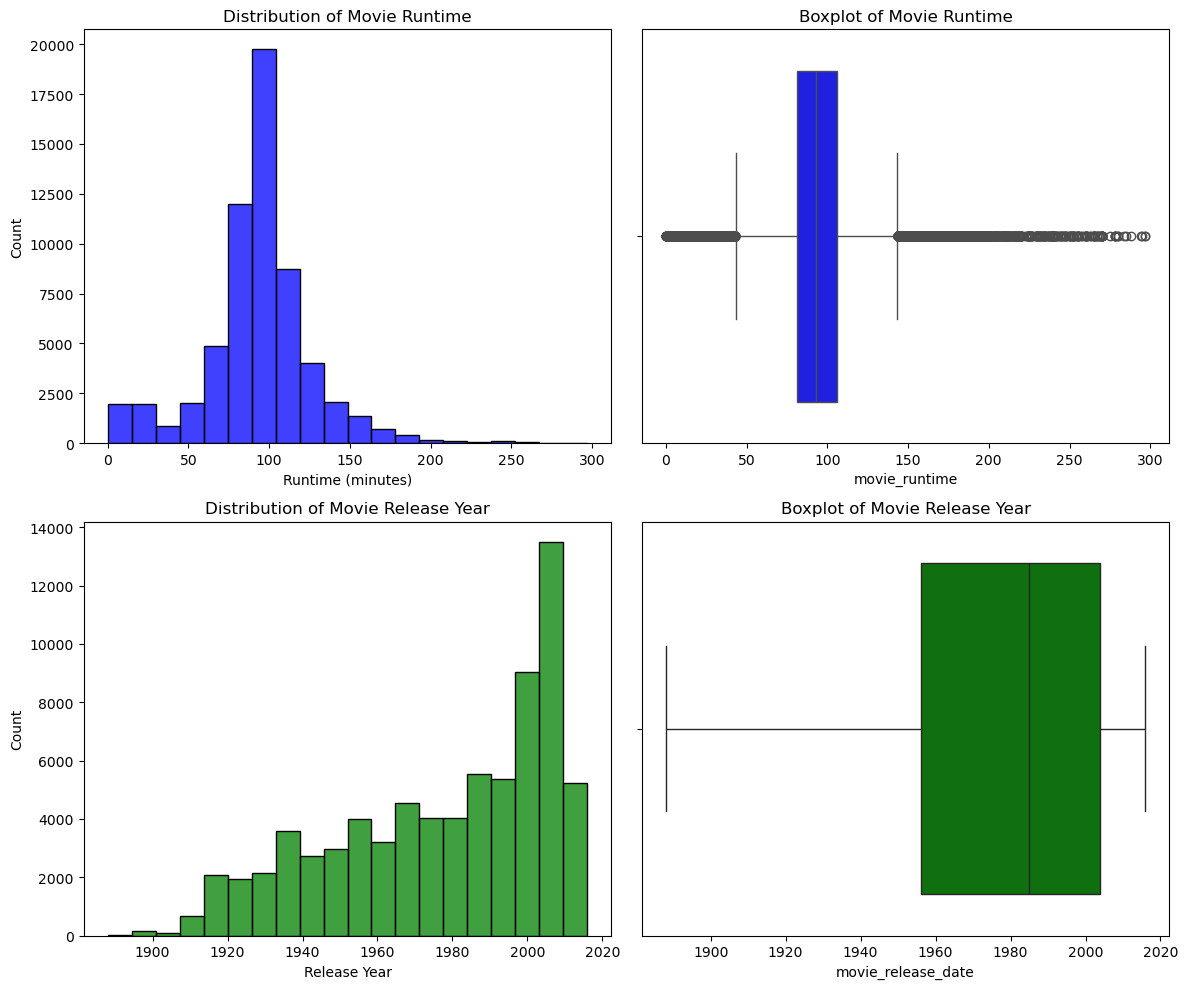

In [17]:
# Create a figure with subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot distribution of movie runtime (no KDE and fewer bins)
sns.histplot(movies[movies['movie_runtime'] < 300]['movie_runtime'].dropna(), kde=False, bins=20, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Distribution of Movie Runtime')
axes[0, 0].set_xlabel('Runtime (minutes)')

# Boxplot for movie runtime
sns.boxplot(x=movies[movies['movie_runtime'] < 300]['movie_runtime'].dropna(), ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Boxplot of Movie Runtime')

# Plot distribution of release year (no KDE and fewer bins)
sns.histplot(movies['movie_release_date'].dropna(), kde=False, bins=20, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution of Movie Release Year')
axes[1, 0].set_xlabel('Release Year')

# Boxplot for movie release year
sns.boxplot(x=movies['movie_release_date'].dropna(), ax=axes[1, 1], color='green')
axes[1, 1].set_title('Boxplot of Movie Release Year')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plots
plt.show()

We notice that the runtime has some extreme outliers. For the release year it is pretty skewed. Therefore, we use the median to impute the missing values.

In [18]:
median_release_year = movies['movie_release_date'].median(skipna=True)
movies['movie_release_date'].fillna(median_release_year, inplace=True)

median_runtime = movies['movie_runtime'].median(skipna=True)
movies['movie_runtime'].fillna(median_runtime, inplace=True)

print((movies.isna().sum() / movies.shape[0]) * 100)

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           0.000000
movie_box_office_revenue    89.722416
movie_runtime                0.000000
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
dtype: float64


/var/folders/34/0658nngn4kg11s2f10mpfs540000gn/T/ipykernel_76057/445208386.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['movie_release_date'].fillna(median_release_year, inplace=True)
/var/folders/34/0658nngn4kg11s2f10mpfs540000gn/T/ipykernel_76057/445208386.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

## We preprocess the summaries

In [ ]:
# Function for basic cleaning of text (Step 1)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Function for tokenization (Step 2)
def tokenize_text(text):
    return word_tokenize(text)

# Function to remove stopwords (Step 3)
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Function for lemmatization (Step 4) - Replace with stemming if needed
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Function for basic cleaning of text (Step 1)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Function for tokenization (Step 2)
def tokenize_text(text):
    return word_tokenize(text)

# Function to remove stopwords (Step 3)
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Function for lemmatization (Step 4)
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply text cleaning to 'plot_summary' in the 'summaries' DataFrame
summaries['clean_plot_summary'] = summaries['plot_summary'].apply(clean_text)

# Apply tokenization (Step 2)
summaries['tokenized_plot_summary'] = summaries['clean_plot_summary'].apply(tokenize_text)

# Apply stopword removal (Step 3)
summaries['filtered_tokens'] = summaries['tokenized_plot_summary'].apply(remove_stopwords)

# Apply lemmatization (Step 4)
summaries['lemmatized_tokens'] = summaries['filtered_tokens'].apply(lemmatize_tokens)

# Show the result
summaries[['plot_summary', 'clean_plot_summary', 'lemmatized_tokens']].head()

In [ ]:
summaries.to_csv('../../data/preprocessed/summaries_preprocessed.csv')